in this project , we used **tensorflow** , starting with Sequential for model building , also we used **Layers** from tensorflow such as **Conv2D** in order to build the model , and finnally  **Metrics** , such as **confusion matrix** , and **classification report** in order to present model performance (accuracy , loss ..)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import requests
import zipfile


**seed** and **set_seed** are used for reproducibility, ensuring that the code gives the same results every time it runs, even when it involves random operations.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def load_data():
    # Try block ensures the fallback to Keras MNIST dataset if downloading from KaggleHub fails
    try:
        # Ensure that a directory named 'data' exists, create it if not
        os.makedirs('./data', exist_ok=True)

        # Define base URL for the dataset hosted on KaggleHub
        dataset_url = "https://www.kagglehub.com/datasets/oddrationale/mnist-in-csv"

        # Construct full URLs for training and test CSV files
        mnist_train_url = f"{dataset_url}/mnist_train.csv"
        mnist_test_url = f"{dataset_url}/mnist_test.csv"

        # Notify user about downloading the training dataset
        print("Downloading training data from KaggleHub...")
        # Send GET request to download training data
        train_response = requests.get(mnist_train_url)
        # Write the content of the response to a local file
        with open('./data/mnist_train.csv', 'wb') as f:
            f.write(train_response.content)

        # Notify user about downloading the test dataset
        print("Downloading test data from KaggleHub...")
        # Send GET request to download test data
        test_response = requests.get(mnist_test_url)
        # Write the content of the response to a local file
        with open('./data/mnist_test.csv', 'wb') as f:
            f.write(test_response.content)

        # Load the training CSV file into a pandas DataFrame
        train = pd.read_csv('./data/mnist_train.csv')
        # Load the test CSV file into a pandas DataFrame
        test = pd.read_csv('./data/mnist_test.csv')

        # Extract pixel values from training data (excluding the label column), reshape to 28x28x1, and normalize to [0, 1]
        X = np.array(train.iloc[:, 1:]).reshape(-1, 28, 28, 1).astype('float32') / 255.0
        # Extract labels (digits) from training data
        y = np.array(train.iloc[:, 0])
        # Do the same for the test data
        X_test = np.array(test.iloc[:, 1:]).reshape(-1, 28, 28, 1).astype('float32') / 255.0
        y_test = np.array(test.iloc[:, 0])

        # Split the training set into training and validation sets (90% train, 10% validation)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

        # Return the prepared datasets
        return X_train, y_train, X_val, y_val, X_test, y_test

    # Catch any exceptions that occur during download or processing
    except Exception as e:
        print(f"Error loading from KaggleHub: {e}")
        print("Falling back to Keras MNIST dataset...")

        # Load MNIST dataset directly from TensorFlow/Keras
        from tensorflow.keras.datasets import mnist
        (X_train, y_train), (X_test, y_test) = mnist.load_data()

        # Reshape to 28x28x1 and normalize pixel values to [0, 1]
        X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
        X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

        # Split into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

        # Return the fallback datasets
        return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
def create_model():
    # Initialize a sequential model, which is a linear stack of layers.
    model = Sequential([

        # ----- First Convolutional Block -----

        # First Conv2D layer: applies 32 filters of size 3x3 over the input image.
        # 'padding="same"' ensures output size = input size (28x28).
        # 'relu' introduces non-linearity by zeroing out negative values.
        # 'input_shape' defines the shape of a single input sample: 28x28 grayscale image with 1 channel.
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),

        # BatchNormalization normalizes the activations of the previous layer for each mini-batch.
        # This reduces internal covariate shift, stabilizes learning, and often accelerates convergence.
        BatchNormalization(),

        # Second Conv2D layer: another 32 filters (3x3), capturing more complex patterns.
        # Stacking convolutional layers before pooling increases feature richness.
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),

        # Normalizes again after second convolution to maintain training stability.
        BatchNormalization(),

        # MaxPooling layer: reduces spatial dimensions by taking the max value in 2x2 windows.
        # This reduces computational load and provides translation invariance.
        MaxPooling2D(pool_size=(2, 2)),

        # Dropout randomly sets 25% of the input units to 0 during training.
        # This helps prevent overfitting by discouraging reliance on any one feature.
        Dropout(0.25),

        # ----- Second Convolutional Block -----

        # Conv2D layer with 64 filters: deeper layer captures more abstract features.
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),

        # Normalize outputs of the layer to stabilize learning.
        BatchNormalization(),

        # Another 64-filter convolution to deepen representation.
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),

        # Normalization again for stable and faster training.
        BatchNormalization(),

        # Pooling again reduces size of feature maps and increases robustness to position.
        MaxPooling2D(pool_size=(2, 2)),

        # Dropout layer to reduce overfitting by randomly deactivating 25% of neurons.
        Dropout(0.25),

        # ----- Third Convolutional Block -----

        # Increase filter count to 128 for even higher-level feature extraction.
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),

        # Normalize for stability.
        BatchNormalization(),

        # Second 128-filter convolution in this block for richer representation.
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),

        # Normalize again.
        BatchNormalization(),

        # Final pooling step to reduce feature maps for fully connected layers.
        MaxPooling2D(pool_size=(2, 2)),

        # Dropout for regularization to combat overfitting.
        Dropout(0.25),

        # ----- Fully Connected Layers -----

        # Flatten transforms the 3D tensor into 1D vector for dense layers.
        Flatten(),

        # Dense (fully connected) layer with 256 units and ReLU activation.
        # Learns high-level combinations of features.
        Dense(256, activation='relu'),

        # Normalize output of dense layer to speed up training and generalize better.
        BatchNormalization(),

        # Dropout: sets 50% of inputs to zero during training. Heavier regularization here due to dense nature.
        Dropout(0.5),

        # Another dense layer with 128 neurons for further high-level abstraction.
        Dense(128, activation='relu'),

        # Normalize again.
        BatchNormalization(),

        # Dropout again to prevent overfitting with 50% drop.
        Dropout(0.5),

        # Output layer: 10 units (digits 0-9), using softmax to convert outputs to class probabilities.
        Dense(10, activation='softmax')
    ])

    # Compile the model: define how it learns.
    # Adam optimizer adapts the learning rate during training for better convergence.
    # Sparse categorical crossentropy is used because labels are integers (not one-hot encoded).
    # Track accuracy metric during training and evaluation.
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Return the compiled model
    return model


let's deep dive into the Architecture implemented in this model , each layer with it's importance ,significance , and why it fits to the dataset.

---

### **1. Input Layer**

```python
input_shape=(28, 28, 1)
```

* **Shape (28, 28, 1)**:

  * The input shape `(28, 28, 1)` corresponds to grayscale images of size 28x28 pixels. The '1' indicates that the images are single-channel (grayscale). If the dataset had RGB images, this would be `3` instead of `1`.

---

### **2. First Convolutional Block**

```python
Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
BatchNormalization(),
Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),
```

* **Conv2D Layer (32 filters, 3x3 kernel)**:

  * **Purpose**: This layer applies 32 convolution filters, each with a `3x3` kernel to the input image. The convolution operation slides these filters over the image to capture spatial features like edges, textures, and simple shapes.
  * **ReLU Activation**: The activation function applied to the output of each filter is `ReLU` (Rectified Linear Unit). ReLU allows only positive activations, which helps introduce non-linearity and speeds up training.
  * **Padding='same'**: This ensures that the output feature map has the same spatial dimensions as the input (28x28 in this case). It pads the image as needed to preserve the input size.
* **BatchNormalization**:

  * **Purpose**: Batch normalization normalizes the output of the convolution layers, stabilizing and speeding up training. It ensures that activations do not get too large or too small, which helps in faster convergence.
* **Second Conv2D (same number of filters)**:

  * **Purpose**: This layer applies another set of 32 convolutional filters. This step allows the model to learn more complex features by combining the simpler features from the previous layer.
* **MaxPooling2D (2x2 pool size)**:

  * **Purpose**: Max pooling reduces the spatial dimensions of the feature maps by taking the maximum value in each `2x2` patch of the feature map. This operation reduces the computational load, prevents overfitting, and helps the model generalize better.
* **Dropout (0.25)**:

  * **Purpose**: Dropout is a regularization technique that randomly sets 25% of the input units to 0 during training. This helps prevent overfitting by forcing the network to not rely on specific neurons.

---

### **3. Second Convolutional Block**

```python
Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),
```

* **Conv2D Layer (64 filters, 3x3 kernel)**:

  * The same procedure as the first convolution block, but with 64 filters instead of 32. This allows the model to learn more complex features, capturing high-level representations of the image (e.g., shapes and patterns).
* **MaxPooling2D (2x2 pool size)**:

  * As in the previous block, max pooling is applied to reduce the spatial dimensions.
* **Dropout (0.25)**:

  * Dropout is applied again to prevent overfitting and improve generalization.

---

### **4. Third Convolutional Block**

```python
Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
BatchNormalization(),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.25),
```

* **Conv2D Layer (128 filters, 3x3 kernel)**:

  * Now with 128 filters, the model learns even more complex features from the images. The more filters used, the more complex features can be learned.
* **MaxPooling2D (2x2 pool size)**:

  * Further downsampling reduces the spatial dimensions, making the model focus on more abstract features instead of fine details.
* **Dropout (0.25)**:

  * Again, dropout is applied to combat overfitting by randomly disabling a fraction of neurons during training.

---

### **5. Fully Connected Layers (Dense Layers)**

```python
Flatten(),
Dense(256, activation='relu'),
BatchNormalization(),
Dropout(0.5),
Dense(128, activation='relu'),
BatchNormalization(),
Dropout(0.5),
Dense(10, activation='softmax')  # 10 classes for digits 0-9
```

* **Flatten**:

  * **Purpose**: The `Flatten` layer takes the 3D output of the last convolutional layer and flattens it into a 1D array. This step is necessary to transition from the convolutional layers to the fully connected (dense) layers.

* **Dense(256, activation='relu')**:

  * **Purpose**: This fully connected layer has 256 neurons and uses the ReLU activation function. Fully connected layers enable the model to learn high-level combinations of features from the convolutional layers. The number of neurons determines the complexity of this layer.

* **BatchNormalization**:

  * **Purpose**: Normalizes the output of the fully connected layer, making training more stable.

* **Dropout (0.5)**:

  * **Purpose**: A higher dropout rate (50%) is applied here to prevent overfitting. As the model transitions to the final output layer, it's crucial to prevent the model from over-relying on specific neurons.

* **Dense(128, activation='relu')**:

  * Another fully connected layer with 128 neurons. It continues to learn complex combinations of features, but with fewer neurons than the previous layer, which may help prevent overfitting.

* **Dense(10, activation='softmax')**:

  * **Purpose**: This is the final output layer, where the number of neurons (10) corresponds to the 10 digits (0-9). The `softmax` activation function converts the raw output values (logits) into probabilities, so the model can output a probability distribution over the 10 classes.

---

### **Overall Architecture Summary**

This architecture is a **deep Convolutional Neural Network (CNN)** designed for **image classification**. The model performs the following:

1. **Convolutional Blocks**: The three convolutional blocks capture hierarchical features from the input images. As the number of filters increases with each block, the model learns increasingly abstract and complex features.
2. **Pooling**: Max pooling helps reduce the dimensionality of the feature maps, allowing the model to focus on high-level features and reduce computational complexity.
3. **Dropout**: Dropout is applied throughout the network to prevent overfitting by randomly disabling a portion of neurons during training.
4. **Fully Connected Layers**: After flattening the feature maps, fully connected layers interpret the high-level features and make a final prediction about the class (digit).
5. **Softmax Output**: The softmax activation in the final layer ensures the output is a probability distribution over the 10 possible digits, making the model capable of classifying any of the 10 digits.

---

### **Why this Architecture Works Well for MNIST:**

* **Convolutional Layers**: CNNs excel at image recognition because they can detect spatial patterns and local dependencies. This is crucial for handwritten digit recognition, where the spatial arrangement of pixels is important.

* **MaxPooling**: Reduces the spatial size, making the model more computationally efficient and reducing the risk of overfitting.

* **Dropout**: Ensures that the model generalizes well by forcing it to learn robust features that are not overly dependent on any single neuron.

* **Softmax Output**: The softmax function ensures that the final output is a probability distribution, making the predictions interpretable.

### **Summary**:

This architecture is a **strong, efficient CNN** for classifying handwritten digits, leveraging multiple convolutional layers, pooling, dropout, and fully connected layers to capture features at multiple scales and make accurate predictions.




### **The Importance of Activation Functions in the Model**

Activation functions play a **crucial role** in deep learning models. Without them, a neural network would behave like a simple linear regression, regardless of how many layers it has. In the context of your convolutional neural network (CNN) for digit recognition, the choice of **ReLU** and **Softmax** activations is intentional and fundamental to its success.

---

### ReLU (Rectified Linear Unit)

**Where it’s used:**
ReLU is applied in **all hidden layers**, including convolutional (`Conv2D`) and fully connected (`Dense`) layers.

**How it works:**
ReLU outputs the input value directly if it is positive; otherwise, it outputs zero. Mathematically:

$$
f(x) = \max(0, x)
$$

**Why it's important:**

1. **Introduces Non-Linearity:**
   Without non-linear activation functions like ReLU, a deep neural network would only be able to learn linear mappings—even if it has many layers. ReLU enables the model to approximate complex functions and patterns in data, which is essential for tasks like image recognition.

2. **Efficient Gradient Propagation:**
   ReLU helps combat the **vanishing gradient problem** that occurs with sigmoid or tanh. It maintains strong gradients for positive values, allowing faster and more effective training of deep networks.

3. **Sparse Activation:**
   Since ReLU outputs zero for negative values, it leads to a sparse network where only some neurons are activated. This sparsity makes the network more efficient and easier to optimize.

4. **Computational Simplicity:**
   Unlike sigmoid or tanh, ReLU is very fast to compute, which makes it ideal for large models and datasets like MNIST.

**Overall Impact:**
ReLU helps your CNN **learn better and faster** by allowing it to develop complex internal representations with minimal computational overhead.

---

### Softmax

**Where it’s used:**
Softmax is applied in the **final output layer** of the model.

**How it works:**
Softmax converts a vector of raw scores (logits) into a probability distribution. Each output represents the model's confidence that the input belongs to a specific class, and all probabilities sum to 1.

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}
$$

**Why it's important:**

1. **Multi-Class Classification:**
   Softmax is the standard for classification problems where **only one class is correct** (e.g., digits 0–9). It enables the network to **assign probabilities** to each class, helping with interpretability and decision-making.

2. **Compatibility with Loss Function:**
   Softmax is designed to work seamlessly with **sparse categorical crossentropy**, which measures the difference between the predicted probability distribution and the true class label.

3. **Encourages Competition Among Classes:**
   Softmax emphasizes the most likely class while de-emphasizing the rest, making the prediction sharper and more decisive.

**Overall Impact:**
Softmax transforms the model's raw output into **clear, interpretable class probabilities**, making it well-suited for tasks like digit classification where a single answer must be chosen from multiple classes.

---

### Summary

In summary, **ReLU** empowers the network to **learn non-linear patterns** efficiently and robustly, while **Softmax** ensures the model outputs are **meaningful probabilities** for multi-class classification. The combination of these two activation functions is fundamental to building a **deep, expressive, and accurate model** for recognizing handwritten digits in the MNIST dataset.

Would you like a version of this text formatted as a PDF or ready to include in a report or presentation?


In [ ]:
# Function to create data generators for training and validation
def create_data_generators(X_train, y_train, X_val, y_val):
    # -------------------------------------------
    # Data augmentation for the training set only
    # -------------------------------------------
    train_datagen = ImageDataGenerator(
        rotation_range=10,        # Randomly rotate images within a range of ±10 degrees
        width_shift_range=0.1,    # Randomly shift images horizontally by 10% of the width
        height_shift_range=0.1,   # Randomly shift images vertically by 10% of the height
        zoom_range=0.1,           # Randomly zoom in/out by up to 10%
        shear_range=0.1           # Apply shearing transformations up to 10%
    )
    # Purpose: These transformations make the model more robust by teaching it to generalize from different perspectives of the same image.
    # This helps reduce overfitting by simulating a larger and more diverse dataset.

    # -------------------------------------------
    # No data augmentation for the validation set
    # -------------------------------------------
    val_datagen = ImageDataGenerator()
    # Purpose: Validation data should reflect real-world performance, so no random changes are applied.

    # -------------------------------------------
    # Create generator objects that yield batches of augmented image data
    # -------------------------------------------
    train_generator = train_datagen.flow(X_train, y_train, batch_size=64)  # Train batches with augmentation
    val_generator = val_datagen.flow(X_val, y_val, batch_size=64)          # Validation batches (no augmentation)

    return train_generator, val_generator


# Function to train the model using the generators and callbacks
def train_model(model, train_generator, val_generator, X_train, y_train, X_val, y_val, epochs=20):
    # ---------------------------------------------------------------
    # Define callbacks that help improve training and prevent overfitting
    # ---------------------------------------------------------------
    callbacks = [
        ReduceLROnPlateau(
            monitor='val_loss',      # Watch the validation loss to determine if the model is improving
            factor=0.2,              # Reduce learning rate by a factor of 0.2 if no improvement
            patience=3,              # Wait 3 epochs before reducing learning rate
            min_lr=0.00001,          # Lower bound on learning rate
            verbose=1                # Print update messages to console
        ),
        EarlyStopping(
            monitor='val_loss',      # Stop training if the validation loss stops improving
            patience=5,              # Wait 5 epochs before stopping
            restore_best_weights=True,  # Revert to the model weights from the epoch with the lowest validation loss
            verbose=1
        )
    ]
    # ✳️ Purpose: These callbacks help the model train efficiently:
    # - ReduceLROnPlateau avoids plateaus by adjusting learning rate dynamically.
    # - EarlyStopping prevents overfitting by stopping training when the model stops improving.

    # ---------------------------------------------------------------
    # Train the model using the generators and provided data
    # ---------------------------------------------------------------
    history = model.fit(
        train_generator,                     # Training data generator
        steps_per_epoch=len(X_train) // 64,  # Number of batches per epoch
        epochs=epochs,                       # Number of training epochs
        validation_data=(X_val, y_val),      # Validation data (not using val_generator to avoid randomness)
        callbacks=callbacks                  # Apply the training callbacks
    )

    return history  # Returns training history containing loss and accuracy metrics


In [ ]:
# Function to train the CNN model using data generators and training callbacks
def train_model(model, train_generator, val_generator, X_train, y_train, X_val, y_val, epochs=20):
    # ---------------------------------------------------------------
    # Callbacks: Tools that help adjust training dynamically
    # ---------------------------------------------------------------
    callbacks = [
        # ReduceLROnPlateau reduces the learning rate when the validation loss stagnates.
        ReduceLROnPlateau(
            monitor='val_loss',      # Monitor the validation loss to detect stagnation or degradation
            factor=0.2,              # Reduce the learning rate by 80% (multiply by 0.2)
            patience=3,              # Wait for 3 epochs of no improvement before reducing the rate
            min_lr=0.00001,          # Do not allow the learning rate to go below this minimum threshold
            verbose=1                # Output updates to the console for monitoring
        ),

        # EarlyStopping stops training if no improvement is seen in the monitored metric.
        EarlyStopping(
            monitor='val_loss',          # Also monitor validation loss to detect overfitting or plateaus
            patience=5,                  # Wait 5 epochs with no improvement before stopping
            restore_best_weights=True,  # Load the best model weights encountered during training
            verbose=1                   # Display when early stopping is triggered
        )
    ]
    #  Why these matter:
    # - These callbacks prevent overfitting and wasted computation by making training adaptive.
    # - EarlyStopping avoids using a model that performs worse on validation than it did earlier.
    # - ReduceLROnPlateau helps escape local minima or plateaus by shrinking the step size.

    # ---------------------------------------------------------------
    # Begin model training using data augmentation from train_generator
    # ---------------------------------------------------------------
    history = model.fit(
        train_generator,                      # Augmented training data from the generator
        steps_per_epoch=len(X_train) // 64,   # Define how many batches are in one epoch (batch size = 64)
        epochs=epochs,                        # Maximum number of epochs to train
        validation_data=(X_val, y_val),       # Static validation data (no generator = no randomness)
        callbacks=callbacks                   # Use learning rate and early stopping callbacks
    )

    # Return training history (loss, accuracy per epoch for both train and validation)
    return history


In [ ]:
# Function to save the trained model to disk
def save_model(model, filepath='handwritten_recognition_model.h5'):
    model.save(filepath)  # Save the full model (architecture + weights + optimizer state) in HDF5 format
    print(f"Model saved to {filepath}")  # Confirmation message

# Why this is important:
# Saving a model allows you to reuse it later for prediction or fine-tuning without retraining.
# The HDF5 format (.h5) is widely supported and efficient for storing entire Keras models.


# Function to visualize training history (accuracy and loss over epochs)
def plot_history(history):
    plt.figure(figsize=(12, 5))  # Create a wide figure to plot both accuracy and loss side by side

    # -----------------------------
    # Plot training and validation accuracy
    # -----------------------------
    plt.subplot(1, 2, 1)  # First subplot in a 1 row × 2 column grid
    plt.plot(history.history['accuracy'])       # Training accuracy over epochs
    plt.plot(history.history['val_accuracy'])   # Validation accuracy over epochs
    plt.title('Model Accuracy')                 # Title of the plot
    plt.ylabel('Accuracy')                      # Y-axis label
    plt.xlabel('Epoch')                         # X-axis label
    plt.legend(['Train', 'Validation'], loc='lower right')  # Legend to distinguish curves

    # -----------------------------
    # Plot training and validation loss
    # -----------------------------
    plt.subplot(1, 2, 2)  # Second subplot
    plt.plot(history.history['loss'])           # Training loss
    plt.plot(history.history['val_loss'])       # Validation loss
    plt.title('Model Loss')                     # Title of the plot
    plt.ylabel('Loss')                          # Y-axis label
    plt.xlabel('Epoch')                         # X-axis label
    plt.legend(['Train', 'Validation'], loc='upper right')  # Legend for clarity

    plt.tight_layout()  # Automatically adjust subplot spacing to prevent overlap
    plt.show()          # Display the plots


In [ ]:
def main():
    print("Loading data...")
    # Load the data using the function 'load_data' which returns training, validation, and test sets
    X_train, y_train, X_val, y_val, X_test, y_test = load_data()

    print("Creating model...")
    # Create a deep learning model using the 'create_model' function (typically a CNN in this case)
    model = create_model()
    model.summary()  # Print the model architecture summary (layers, output shapes, parameters)

    print("Creating data generators...")
    # Prepare data generators for training and validation sets with augmentation for training
    train_generator, val_generator = create_data_generators(X_train, y_train, X_val, y_val)

    print("Training model...")
    # Train the model using the data generators, callbacks, and other provided data
    history = train_model(model, train_generator, val_generator, X_train, y_train, X_val, y_val)

    print("Evaluating model...")
    # Evaluate the model on the test dataset and get the accuracy and predictions
    test_acc, y_pred = evaluate_model(model, X_test, y_test)

    print("Plotting training history...")
    # Plot the training and validation accuracy and loss curves
    plot_history(history)

    print("Saving model...")  # Inform the user that the model is being saved to disk
    # Save the trained model to a file for later use or inference
    save_model(model)

    print("Done!")
    return model, history, test_acc  # Return the trained model, history, and test accuracy for further use


Loading data...
Error loading from KaggleHub: HTTPSConnectionPool(host='www.kagglehub.com', port=443): Max retries exceeded with url: /datasets/oddrationale/mnist-in-csv/mnist_train.csv (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7e8e6e5b5bd0>: Failed to establish a new connection: [Errno 111] Connection refused'))
Falling back to Keras MNIST dataset...
Creating model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 619,114 (2.36 MB)

 Trainable params: 617,450 (2.36 MB)

 Non-trainable params: 1,664 (6.50 KB)

Creating data generators...
Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.7006 - loss: 0.9876 - val_accuracy: 0.9775 - val_loss: 0.0815 - learning_rate: 0.0010
Epoch 2/20
  1/843 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9219 - loss: 0.2439

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - accuracy: 0.9219 - loss: 0.2439 - val_accuracy: 0.9797 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 3/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.9582 - loss: 0.1458 - val_accuracy: 0.9817 - val_loss: 0.0600 - learning_rate: 0.0010
Epoch 4/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.9375 - loss: 0.1495 - val_accuracy: 0.9827 - val_loss: 0.0562 - learning_rate: 0.0010
Epoch 5/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.9714 - loss: 0.0948 - val_accuracy: 0.9893 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 6/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.9844 - loss: 0.0920 - val_accuracy: 0.9892 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 7/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.9774 - loss: 0.0767 - val_accuracy: 0.9885 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 8/20
843/843 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 1.0000 - loss: 0.0226

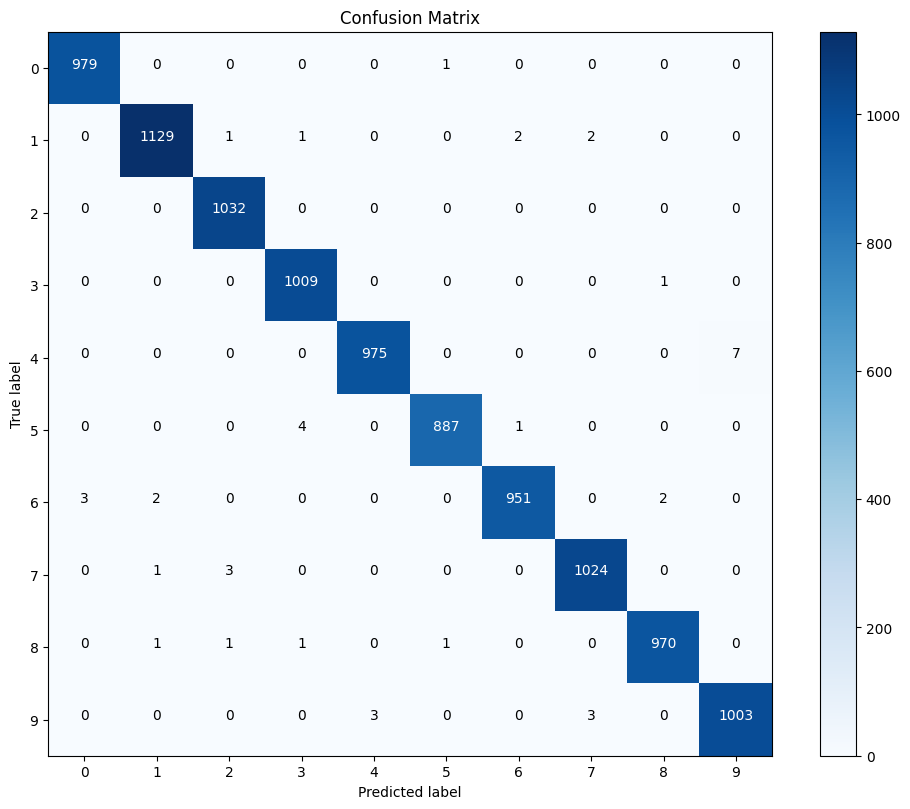

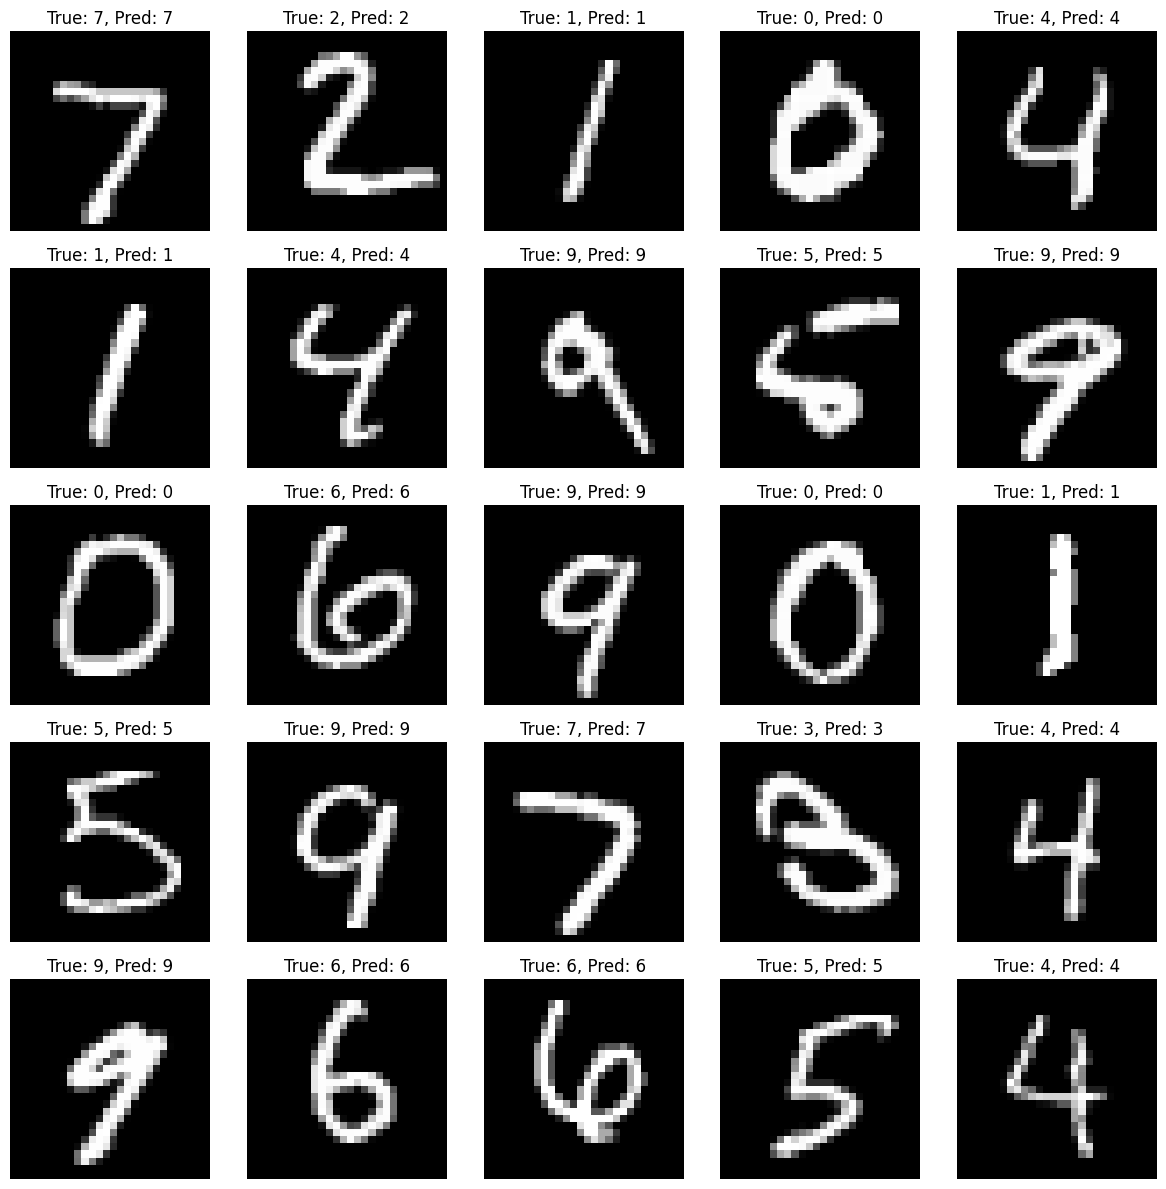

Plotting training history...


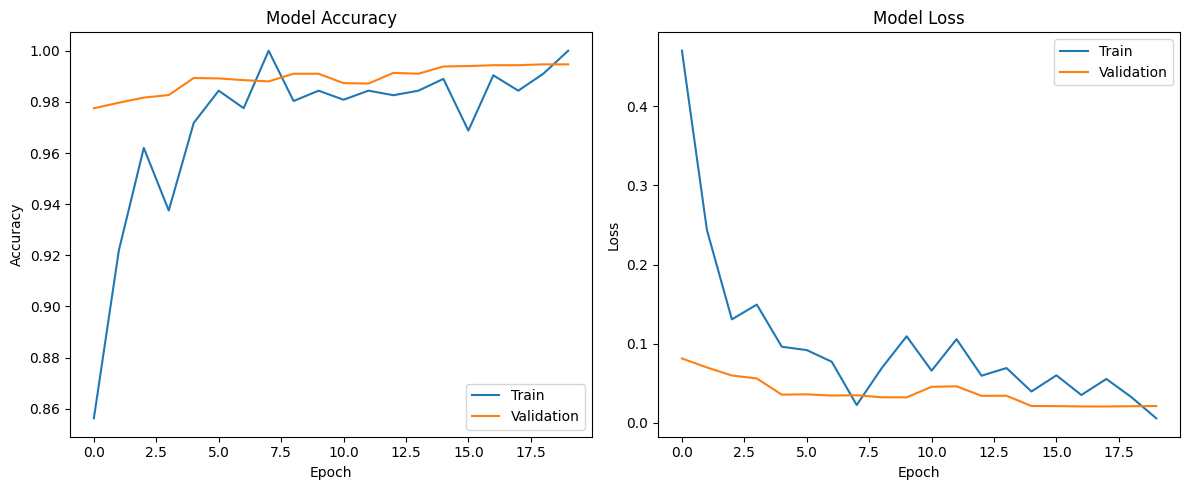

Saving model...
Model saved to handwritten_recognition_model.h5
Done!


In [ ]:
model, history, test_acc = main()

In [ ]:
def predict_image(model, image_path):
    from PIL import Image   # Import the Python Imaging Library to handle image loading and manipulation
    import numpy as np      # Import NumPy for array manipulation

    # ------------------------------------------------------
    # Load and preprocess the image
    # ------------------------------------------------------
    img = Image.open(image_path).convert('L')  # Open the image and convert it to grayscale ('L' mode)
    img = img.resize((28, 28))  # Resize the image to 28x28 pixels (MNIST images are 28x28)
    img_array = np.array(img).reshape(1, 28, 28, 1).astype('float32') / 255.0  # Normalize image pixel values
    # Explanation:
    # - `convert('L')` ensures the image is grayscale (since MNIST is grayscale).
    # - Resizing ensures the image fits the input shape expected by the model (28x28x1).
    # - Reshaping is necessary to match the input dimensions the model expects: (1, 28, 28, 1) for a single image.
    # - Normalizing the pixel values by dividing by 255.0 converts the pixel range from [0, 255] to [0, 1].

    # ------------------------------------------------------
    # Make prediction with the model
    # ------------------------------------------------------
    prediction = model.predict(img_array)  # Use the model to predict the class of the image
    digit = np.argmax(prediction)  # The predicted digit is the class with the highest probability
    confidence = np.max(prediction) * 100  # The confidence is the highest probability, converted to percentage

    # ------------------------------------------------------
    # Print prediction results
    # ------------------------------------------------------
    print(f"Predicted digit: {digit}")  # Output the predicted digit
    print(f"Confidence: {confidence:.2f}%")  # Output the confidence as a percentage (up to two decimal places)

    # ------------------------------------------------------
    # Display the image and prediction result
    # ------------------------------------------------------
    plt.imshow(img, cmap='gray')  # Display the image using a grayscale color map
    plt.title(f"Predicted: {digit} (Confidence: {confidence:.2f}%)")  # Title showing the predicted digit and confidence
    plt.axis('off')  # Hide the axis for better visualization
    plt.show()  # Display the image with the prediction title

    return digit, confidence  # Return the predicted digit and its confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted digit: 6
Confidence: 99.99%


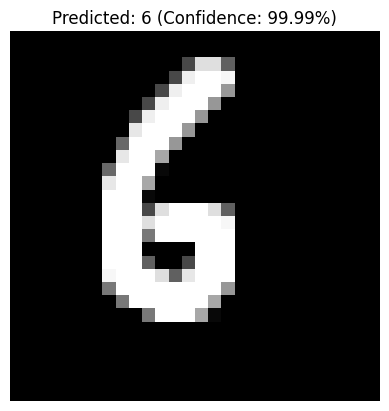

(np.int64(6), np.float32(99.99356))

In [ ]:
predict_image(model,'/content/images/A1.png')